# Оглавление: 
2. [Дашборд и презентация](#dashboard)
3. [Описание проета](#descript)
4.[Предобработка данных](#preprocess)
5.[Исследовательский анализ данных](#analysis)
6.[Сегментация клиентов](#segment)
7.[Проверка гипотез](#check)
8.[Выводы](#cncl)

# <a name="dashboard">Дашборд и презентация</a> 


Дашборд: https://public.tableau.com/views/_16584298036940/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link

Презентация: https://disk.yandex.ru/i/GEAls0gv7Eo4lw

# <a name="descript"> Описание проекта и цель:</a> 

**Описание проекта:**

Заказчик: Небольшой региональный банк, располагается в Ярославле, Ростов Великий и Рыбинск.
Проблема: Банк столкнулся с оттоком клиентов. Менеджеры банка полгают, что проблема оттока связана с одним из продуктов. 

**Цель:**

Проанализировать клиентов банка, провести сегментацию клиентов по признакам, которые могут влиять на отток, сформировать и проверить статистические гипотезы на равернство срених между продуктами.

In [1]:
import os
from urllib.error import HTTPError

import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style='white')
import matplotlib.pyplot as plt

from scipy import stats as st
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# <a name="preprocess"> Предобработка данных:
</a> 

* проверить корректность полученных данных, 
* обработать дубликаты, 
* удалить пустые строки, если они есть, 
* наименования, привести к единому стилю, если в них есть проблемы, 
* привести типы, 
* заменить пропущенные значения. 

In [2]:
local_path = 'C:\\Dev\\Jupyter\\dist\\downloads\\bank_dataset_new.csv'
web_path = 'https://drive.google.com/uc?export=download&id=1avzNMbAm9vXJWBpGUK6mZxGgGl'

if os.path.exists(local_path):
    df = pd.read_csv(local_path)
else:
    try:
        df = pd.read_csv(web_path)
    except HTTPError:
        print("Oops!")
        df = pd.DataFrame()
df.head()

,Unnamed: 0,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
0,0,258835,673,Ростов,Ж,32,0,467428.54,1,0,1,81011.65,True
1,1,96660,691,Ростов,Ж,31,3,65548.60,1,0,1,57005.02,True
2,2,99838,679,Ростов,Ж,30,1,686979.40,1,1,1,149687.98,True
3,3,216099,717,Рыбинск,Ж,25,2,1292171.92,1,0,1,19502.68,True
4,4,120240,744,Рыбинск,Ж,37,1,1390927.97,1,0,1,36861.24,True


- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — приблизительная оценка собственности клиента. Чем больше баллов, тем более ценной собственностью обладает клиент по нашим данным.
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент [1, 3, 4, 0, 2],
- `credit_card` — есть ли кредитная карта,
- `last_activity` — был ли клиент активен последнее время [1, 0],
- `salary` — заработная плата клиента,
- `churn` — уходит или нет.

столбец `Unnamed: 0` можно удалить, он дублирует инексы по строкам

In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
0,258835,673,Ростов,Ж,32,0,467428.54,1,0,1,81011.65,True
1,96660,691,Ростов,Ж,31,3,65548.60,1,0,1,57005.02,True
2,99838,679,Ростов,Ж,30,1,686979.40,1,1,1,149687.98,True
3,216099,717,Рыбинск,Ж,25,2,1292171.92,1,0,1,19502.68,True
4,120240,744,Рыбинск,Ж,37,1,1390927.97,1,0,1,36861.24,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7706 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  bool   
dtypes: bool(1), float64(2), int64(7), object(2)
memory usage: 869.3+ KB


In [5]:
print (df.isna().mean()*100)

userid            0.00
score             0.00
city              0.00
gender            0.00
age               0.00
equity            0.00
balance          22.94
products          0.00
credit_card       0.00
last_activity     0.00
salary            0.00
churn             0.00
dtype: float64


По типам значений и названиям колонок каких-либо неожиданных значений нет, в корректировках они не нуждаются.  Есть проблема с пропущенными значениями `balance`  поскольку таких значений 23%, это очень много, удалить их нельзя. Далее в ходе исследования посмотрим, как можно будет поступить с этими пропусками. 

In [6]:
df[df.isnull().any(1)]


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
1439,154581,358,Рыбинск,М,32,0,NaN,1,1,0,68687.05,False
1442,92746,431,Рыбинск,М,31,0,NaN,1,1,1,123472.49,False
1443,161908,350,Ярославль,Ж,29,0,NaN,1,1,0,109259.26,False
1453,155767,496,Ярославль,Ж,33,0,NaN,1,1,0,101401.75,False
1454,122713,506,Ярославль,Ж,33,0,NaN,1,1,0,120079.69,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9993,248568,552,Рыбинск,Ж,43,0,NaN,1,1,0,115193.33,False
9994,145758,466,Ярославль,Ж,40,0,NaN,1,0,0,11553.53,False
9995,186605,466,Рыбинск,М,42,0,NaN,1,1,1,85203.00,False
9996,204842,311,Ярославль,М,27,0,NaN,1,1,0,141654.61,False


Пустые строки в балансе встречаются в основном по количеству продуктов  1 и 2 в с наличием кредитной карты, таким образом, при количестве продуктов 1 или 2 и значении `credit_card` = 1, клиент пользуется кредитными средствами всегда. В ситуации когда `credit_card` =0 и  `products`= 1 клиент пользуется вероятнее всего также кредитными средствами в виде кредитного продукта (например потребительский кредит). Эти строки можно будет занулить, чтобы они не мешали при проведении A/B теста 


In [7]:
df['balance'] = df['balance'].fillna(0)

In [8]:
print(df[df.duplicated()].head())

Empty DataFrame
Columns: [userid, score, city, gender, age, equity, balance, products, credit_card, last_activity, salary, churn]
Index: []


Дубликаты отсутсвуют.

Добаввим в датасет столбцы с кодировкой категориальных данных по локации и половому признаку. Используем для этого метод One Hot Encoding, что поможет в анализе портрета нашего клиента. Чтобы не созавать большое количество столбцов, по половому признаку, создадим новый столбец `gender_cat` где будут значения согласно двоичному кодированию.

In [9]:
df['city_c'] = df['city'].copy()
df = pd.get_dummies(df, columns=['city_c'], prefix=['city'])
df['gender_cat'] = np.where(df['gender'] == 'Ж', 1, 0)
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_cat
0,258835,673,Ростов,Ж,32,0,467428.54,1,0,1,81011.65,True,1,0,0,1
1,96660,691,Ростов,Ж,31,3,65548.60,1,0,1,57005.02,True,1,0,0,1
2,99838,679,Ростов,Ж,30,1,686979.40,1,1,1,149687.98,True,1,0,0,1
3,216099,717,Рыбинск,Ж,25,2,1292171.92,1,0,1,19502.68,True,0,1,0,1
4,120240,744,Рыбинск,Ж,37,1,1390927.97,1,0,1,36861.24,True,0,1,0,1


# <a name="analysis">  Исследовательский анализ данных </a>

* Изучить средние значения и стандартные отклонения для всех клиентов, остающихся клиентов и клиентов-оттока,
* Изучить как влияет на отток локация и пол, 
* Проверить распределение оттока по признакам и вывить основные с наибольшим оттоком,  
* Проверить как количество продуктов продуктов влияет на отток, 
* Сегментировать клиентов по ключевым показателям, 
* Проверить динамику оттока внутри каждой группы

##  Изучить средние значения и стандартные отклонения для всех клиентов, остающихся клиентов и клиентов-оттока


Посмотрим внимательнее на характеристики нашего пользователя и составим портрет среднего клиента.


In [10]:
print ('Портрет среднестатистического клиента банка:') 
df.describe().T

Портрет среднестатистического клиента банка:


,count,mean,std,min,25%,50%,75%,max
userid,10000.0,153706.098000,6.888353e+04,1436.00,98693.0000,159656.00,212808.50,2.640130e+05
score,10000.0,603.584900,1.321770e+02,300.00,506.0000,610.00,713.00,8.500000e+02
age,10000.0,42.837100,1.212851e+01,18.00,34.0000,40.00,51.00,8.600000e+01
equity,10000.0,1.747200,1.713764e+00,0.00,0.0000,1.00,3.00,9.000000e+00
balance,10000.0,600787.686586,1.874689e+06,0.00,25047.0350,268677.72,771976.43,1.263859e+08
products,10000.0,1.115900,4.107116e-01,0.00,1.0000,1.00,1.00,4.000000e+00
credit_card,10000.0,0.842300,3.644777e-01,0.00,1.0000,1.00,1.00,1.000000e+00
last_activity,10000.0,0.499800,5.000250e-01,0.00,0.0000,0.00,1.00,1.000000e+00
salary,10000.0,95468.122363,1.325737e+05,380.84,31449.2925,63440.57,108795.85,1.378131e+06
city_Ростов,10000.0,0.143100,3.501923e-01,0.00,0.0000,0.00,0.00,1.000000e+00


Наш клиент в возрасте 40 -42 года, с баллоом  кредитного скоринга - 610, в собственности клиента веротянее нвсего только небольшие накопления, возможно в виде вклада, с балансом менее 500тыс руб, использует 1 продукт, владелец кредитной карты (вероятнее всего это и есть единственный продукт ), неактивный, с медианной зарплатой в 63 тыс руб. 59,1 %  из Ярославля, 27% из Рыбинска и 14% и Ростова, с одинаковым распределением по половому признаку.

In [11]:
print ('Отток:') 
df.query('churn == 1').describe().T


Отток:


,count,mean,std,min,25%,50%,75%,max
userid,1437.0,1.532021e+05,6.862017e+04,3450.00,99284.00,159286.00,211730.00,263963.00
score,1437.0,7.283361e+02,5.904839e+01,419.00,687.00,726.00,770.00,850.00
age,1437.0,3.917954e+01,1.022333e+01,18.00,32.00,37.00,46.00,79.00
equity,1437.0,2.765484e+00,1.829800e+00,0.00,1.00,3.00,4.00,9.00
balance,1437.0,1.547334e+06,2.941579e+06,1476.51,433219.17,995244.91,1669049.39,67126874.68
products,1437.0,1.441893e+00,8.413074e-01,0.00,1.00,1.00,1.00,4.00
credit_card,1437.0,5.386221e-01,4.986796e-01,0.00,0.00,1.00,1.00,1.00
last_activity,1437.0,8.503827e-01,3.568200e-01,0.00,1.00,1.00,1.00,1.00
salary,1437.0,1.190438e+05,1.542005e+05,3325.20,46656.59,82117.28,127408.59,1378131.45
city_Ростов,1437.0,1.391788e-01,3.462536e-01,0.00,0.00,0.00,0.00,1.00


Посмотрим на самые интересные показатели по оттоку клиентов: 
- `score` — Медианные значения баллов  кредитного скоринга составляют 726. при этом примерно 75% выборки находится примерно до 770,
- `equity` — приблизительная оценка собственности клиента. Медианное значение 3, т.е. это клиенты, у которых нет дорогой собственности в виде актива. Вероятнее всего это автомобиль эконом класса/небольшие накопления/небольшой инвестиционный портфель, 
- `balance` — медианное значение баланса менее 1 млн ед, 
- `products` — с использованием одного продукта, 
- `credit_card` — с наличием кредитной карты
- `last_activity` — активный клиент,
- `salary` — заработная плата клиента в 82тыс ед,

Если коротко описать портрет клиента на отток, то это пользователь 37-39 лет, с оценкой собственноси 3 балла, с средним балансом менее 1 млн.руб, использующий 1 продукт, имеющий на руках кредитную карту, клиент активен и медианной зп 82тыс.руб, преимущественно мужчины (61%). 65,3 % уходящих клиентов из Ярославля, 21% из Рыбинска, 14% из Ростова

In [12]:
print ('Действующий:') 
df.query('churn == 0').describe().T

Действующий:


,count,mean,std,min,25%,50%,75%,max
userid,8563.0,153790.679552,6.893126e+04,1436.00,98467.50,159679.00,213073.000,2.640130e+05
score,8563.0,582.649772,1.294908e+02,300.00,490.00,581.00,681.000,8.500000e+02
age,8563.0,43.450893,1.231414e+01,18.00,34.00,41.00,52.000,8.600000e+01
equity,8563.0,1.576317,1.632524e+00,0.00,0.00,1.00,3.000,9.000000e+00
balance,8563.0,441942.932198,1.573994e+06,0.00,0.00,207137.25,603679.225,1.263859e+08
products,8563.0,1.061194,2.396989e-01,1.00,1.00,1.00,1.000,2.000000e+00
credit_card,8563.0,0.893262,3.087983e-01,0.00,1.00,1.00,1.000,1.000000e+00
last_activity,8563.0,0.440967,4.965319e-01,0.00,0.00,0.00,1.000,1.000000e+00
salary,8563.0,91511.774835,1.281745e+05,380.84,30100.26,60043.72,105283.410,1.327784e+06
city_Ростов,8563.0,0.143758,3.508647e-01,0.00,0.00,0.00,0.000,1.000000e+00


Наш действующий клиент с медианным кредитным рейтингом 581, что в целом ниже в разрезе общей группы, средний возраст 41- 43года, с приблизительной оценкой собственности 1 балл, балансом на счете менее 400 тыс руб, количеством продуктов 1, наличием кредитной карты, зарплатой 60 тыс.руб, по половому признаку значительных различий также нет. Преимущественно это клиенты из Ярославля 58% , Рыбинска 28% и Ростова 14%.

## Влияние локации и полового признака на отток

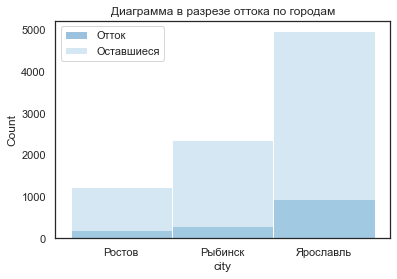

In [13]:
sns.histplot(df, x = 'city', hue = 'churn', palette = 'Blues' ).set_title('Диаграмма в разрезе оттока по городам')
plt.legend(['Отток', 'Оставшиеся']);

Большая часть клиентов-оттока из Ярославля, также можно обратить внимание, что больше всего клиентов из Ярославля

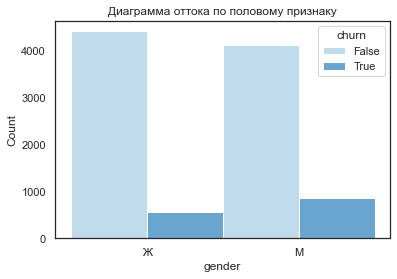

In [14]:
sns.histplot(df, x = 'gender' , hue = 'churn' ,  multiple = 'dodge', palette = 'Blues').set_title('Диаграмма оттока по половому признаку');


Отток по разбивке по половому признаку больше у мужчин, при этом женщин среди клиентов, которые остаются с нашим банком больше. 


## Распределение признаков в разрезе оттока

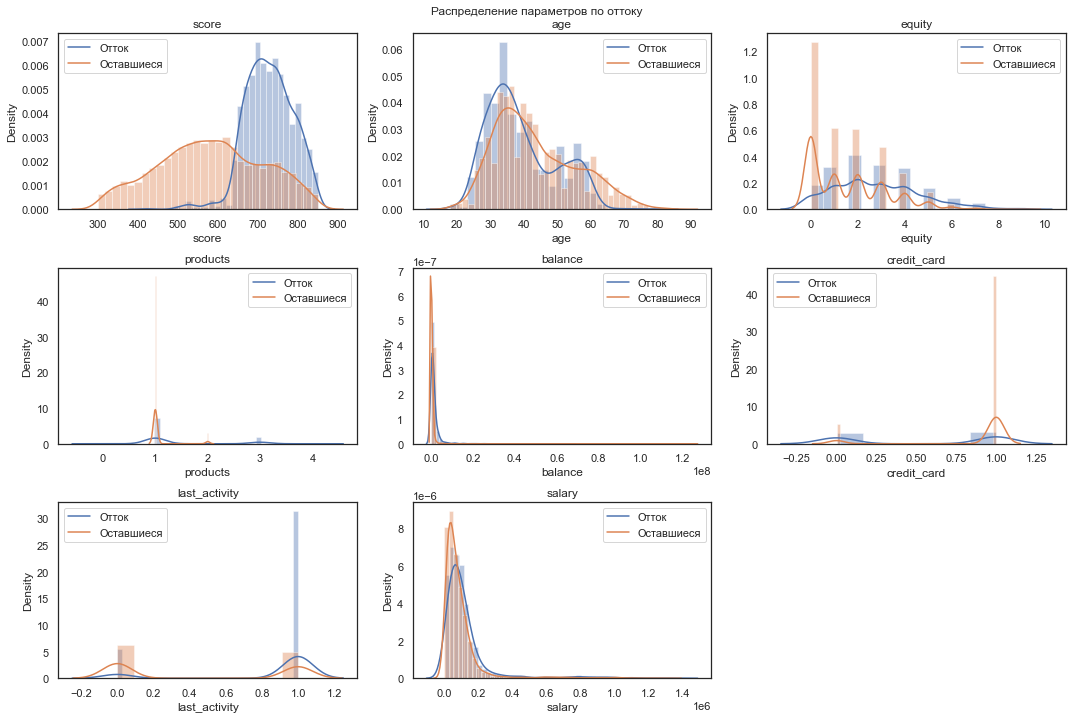

In [15]:
res = ['score', 'age', 'equity','products', 'balance', 'credit_card', 'last_activity','salary']
col_count, row_count = 3,4
plt.figure(figsize = (15,13))

for i, j in enumerate(res):
    for chn in df['churn'].unique():
        current = df.query('churn == @chn')
        sns.distplot(current[j], ax = plt.subplot(row_count, col_count, i+1))
        
    plt.title(j)
    plt.legend(['Отток', 'Оставшиеся'])
    
    
plt.suptitle('Распределение параметров по оттоку')

plt.tight_layout() 

**Отток по `score`:**
    Отток растет согласно графика у клиентов, с высокими оценками скоринга. Пиковые значения сосредоточены в 700 - 800 ед.

**Отток по `age`:**
   Наибольший отток среди клиентов от 20 - 35 лет, среди клиентов старшего возраста, такой отток глобально не наблюдается. Есть небольшой всплеск на графике оттока в возрастной гуппе 56-59 лет, но в точке 60 он начинает снижаться. Т.о. стоит ориентироваться на более консервативные инструменты,
    
**Отток по `equity`:**
    Пик оттока приходится на 2, которое является  небольшим значением личных активов клиента. Если смотреть на кривую распределения, то в значения 2-3 значения оттока и остающихся клиентов не имеют особых различий, т.е. в оценки собственнсти в значених 2-3 уходит больше половины клиентов. 
 
**Отток по `products`:**
   Основной отток приходится на пользователей с количеством продуктов 1 и 3, далее все значения располагаютс ближе к 0
    
 **Отток по `balance`:**
     Отток расположен, в большей степени в нулевых или около нулевых значений, т.е. у клиентов на счтаех небольшие суммы. 
 
 **Отток по `credit_card`:**
    В рамках распределения также нельзя говорить о высоком влиянии оттока при наличии/отстуствии кредитной карты. Пики кривой оттока примерно на одном уровне, как при использовании кредитной карты, так и при ее неиспользовании.
    
**Отток по `last_activity`:**
   Наиболее активные клиенты, чаще всего уходят, что является оределенным сюрпризом. 
  
**Отток по `salary`:**
  Величина уходящих клиентов также высокая, но среди клиентов с минимальными доходами.
  
  

Посмотрим на графики в масштабе, для этого часть данных с высокими показателями остатка средств на счете, нам придется откинуть, так как они мешают увидеть детальнее все что происходит на графике

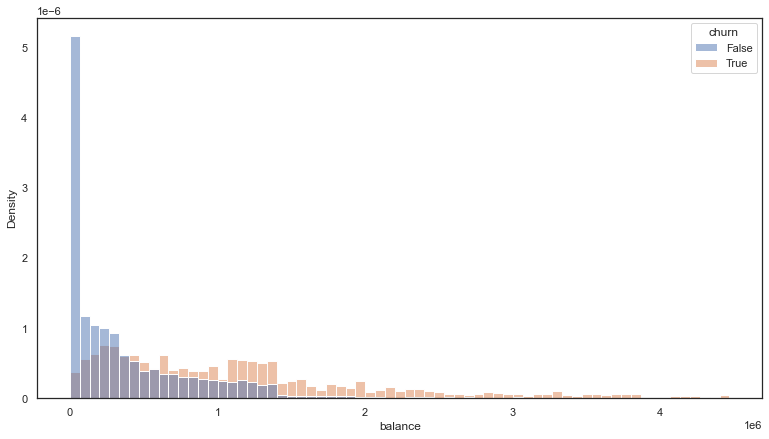

In [16]:
plt.figure(figsize = (13,7))
q95_b = np.percentile(df['balance'], 99)
sns.histplot(data = df.query('balance <= @q95_b'), x= 'balance', hue = 'churn', stat='density', common_norm = False);

Чаще всего из банка уходят клиенты с наибольшими остатками средств на счете, плотность распределения примерно одинаковая независимо от сумм на счете примерно до 1,5 млн.руб, после чего у клиентов с большим капиталом плотность распределения снижается. Теперь посмотрим на распределение в зарплате также в масштабе

<AxesSubplot:xlabel='salary', ylabel='Density'>

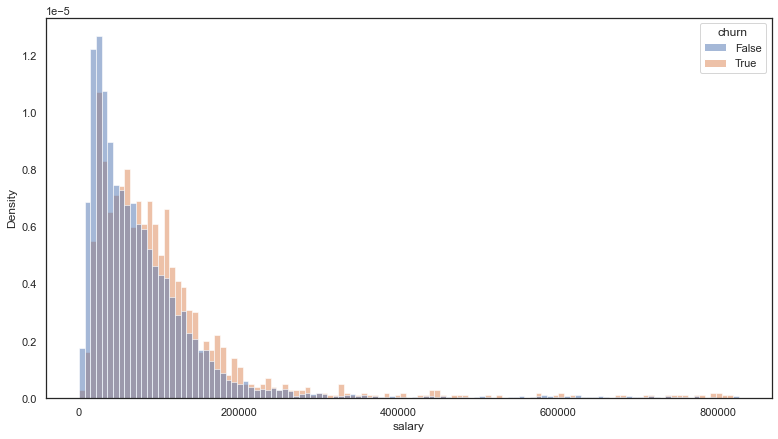

In [17]:
plt.figure(figsize = (13,7))
q95_s = np.percentile(df['salary'], 99)
sns.histplot(data = df.query('salary <= @q95_s'), x= 'salary', hue = 'churn', stat='density', common_norm = False)

Основной пик приходится на минимальные и средние зарплаты, плотность распределения в диапазоне от 30 -150 тыс самая высокая, после чего начинает снижаться, т.е. в банке выгоднее оставаться при высоких капиталах

## Матрица корреляции

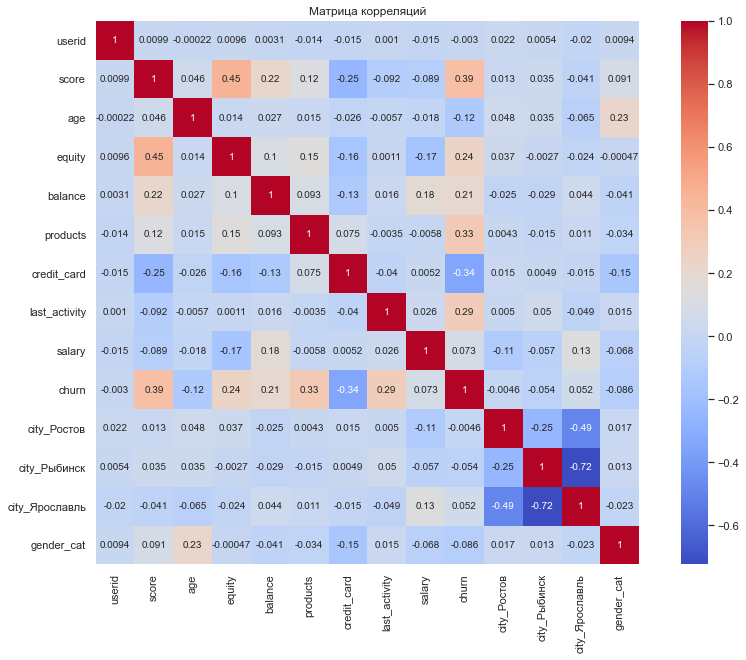

In [18]:
plt.figure(figsize = (15,10))
sns.heatmap(data = df.corr(), annot = True, square = True, cmap = 'coolwarm').set_title('Матрица корреляций');

Корреляции между признаками нет, рассмотрим связи между признаками и продуктами, в разрезе оттока

## Изучение взаимосвязи между  количеством продуктов, в разрезе оттока, по признакам

In [19]:
prod_churn = round(df.query('products != 0').pivot_table(index = 'products',  values = ['city_Ярославль', 
    'city_Рыбинск', 'city_Ростов' ,'churn'], aggfunc =('count' , 'mean')).reset_index(),3)

prod_churn

products churn        city_Ростов        city_Рыбинск        city_Ярославль  \
           count   mean       count   mean        count   mean          count   
0        1  9161  0.122      9161.0  0.142       9161.0  0.267         9161.0   
1        2   524  0.000       524.0  0.183        524.0  0.303          524.0   
2        3   306  1.000       306.0  0.124        306.0  0.196          306.0   
3        4     8  1.000         8.0  0.000          8.0  0.125            8.0   

          
    mean  
0  0.592  
1  0.513  
2  0.680  
3  0.875

Text(0.5, 0.98, 'Взаимосвязи между количеством продуктов, в разрезе оттока')

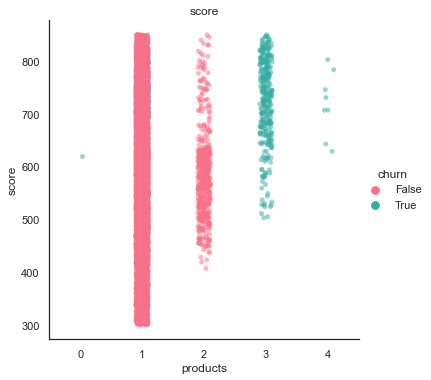

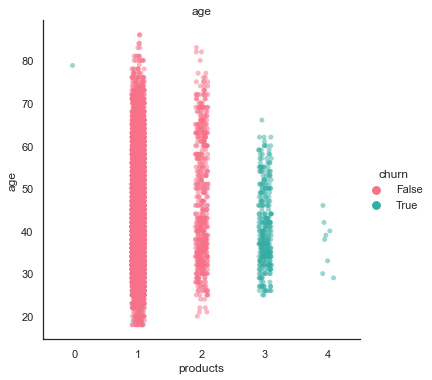

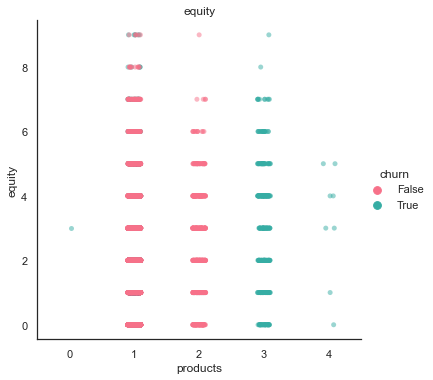

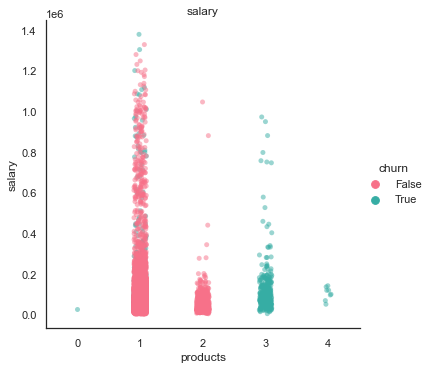

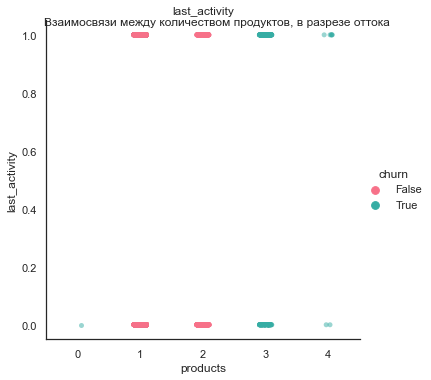

In [20]:
param = ['score', 'age', 'equity', 'salary', 'last_activity']

for i in param:

    sns.catplot  (x = 'products', y = i, hue = 'churn',data = df, alpha = 0.5, palette = 'husl')
    plt.title(i)
plt.suptitle('Взаимосвязи между количеством продуктов, в разрезе оттока')

1. Количество отсутствия  продуктов (0) не рассматриваем, так как это только один клиент.  
2. Большой отток в зависимости от количества продуктов наблюдается в `score` у клиентов с количеством продуктов 3 и 4 -это клиенты с высокой кредитной оценкой.  Уходят клиенты с хорошим кредитным рейтингом выше 550 баллов, это примерно от 50% перцентили и выше.
Такая же ситуация наблюдается по возвратсному признаку `age`, `equity`, `salary`,`last_activity`. 
3. Больше всего отток наблюдается у клиентов с количеством продуктов 3, затем 4. 
4. Отток при использовании 1 продукта составляет около 12 % , но в количественном выражении он больше чем отток в 3 и  группе
5. Клиенты Ярославля по прежнему продолжают уходить, вероятнее всего такой большой отток мог быть связан с акционным оформлением кредитных карт с наличием каких-либо бонусов, после чего клиенты стали возвращаться обратно и закрывать свои продукты или с проблемами в отделении, менеджерам стоит проверить отделения в Ярославле. 
6. Стоит отметить, что мы также теряем активных клиентов использующих 4, 3 или 1 продукт. Чаще всего клиенты пользуются 2 продуктами, вероятнее всего проблема в неперспективности предлагаемых продуктов / невыгодных условиях для активных клиентов, которые исполmзуют по несколько продуктов. 

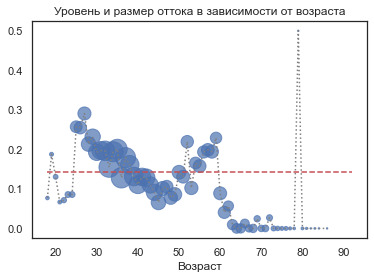

In [21]:
df_age = df.groupby('age').agg({'churn':['mean','count']}).droplevel(0,1).set_axis(['churn','share'],1)
plt.plot(df_age.index, df_age.churn, linestyle=":", color="gray")
plt.scatter(df_age.index,df_age.churn,s=df_age.share,alpha=0.7)
plt.title("Уровень и размер оттока в зависимости от возраста")
plt.xlabel("Возраст")
plt.hlines(df.churn.mean(),18,92,ls='--',color='r');

По возврасту клиентов отток увеличивается от 25-45 лет он наиболее максимален, далее от 45-60 лет он начинается уменьшаться, после 60 лет отток минимизируется. 

Можно будет разделить клиентов по группам: 
- до 25 и добавить их в группу 1, 
- от 25-45 в группу 2, 
- от 45-60  в группу 3, 
- все остальные попадут в группу 4. 


## Изучение взаимосвязи между возрастными группами, в разрезе продуктов по оттоку клиентов

In [22]:
def cat(row):
    if row < 25:
        return '1'
    if 25 <= row <= 45:
        return '2'
    if 45 < row <= 60:
        return '3'

    return '4'

df['age_cat'] = df['age'].apply(cat)

Посмотрим как распределяется отток согласно возрастной группе, в разрезе активности и городов: 

In [23]:
round (df.query('products != 0').pivot_table( index = 'age_cat' , values = ['last_activity', 'city_Ярославль', 'city_Рыбинск', 
                'city_Ростов' ,'churn'], aggfunc = ['count' , 'mean']).reset_index(),3)



age_cat count                                                         mean  \
          churn city_Ростов city_Рыбинск city_Ярославль last_activity  churn   
0       1   165         165          165            165           165  0.097   
1       2  6301        6301         6301           6301          6301  0.166   
2       3  2499        2499         2499           2499          2499  0.142   
3       4  1034        1034         1034           1034          1034  0.015   

                                                         
  city_Ростов city_Рыбинск city_Ярославль last_activity  
0       0.152        0.261          0.588         0.576  
1       0.131        0.254          0.615         0.496  
2       0.158        0.290          0.551         0.489  
3       0.181        0.281          0.538         0.537

Наибольший отток среди  возврастных групп: 
1. группа 1 **(клиенты  до 25 лет)** - отток  10%, в количественном измерении он минимален.
2. группа 2 **(25-45лет)** - отток 17%, в количественном измерении это максимальные значения оттока, по возрастным группам. Чаще всего это клиенты из "семейного сегмента" которые могут быть обременены кредитами, возможно также стоит обратить внимание на  кредитную линейку продуктов, которая существует в банке, 
3. группа 3 **(45-60 лет)** - отток 14% также как и в группе 2 это может быть "семейная группа" клиентов, которые могут обременены кредитами, но также заинтересованы в консервативных инструментах,
4. группа 4 **(клиенты 60+)** - отток менее 2 %. Для данного типа клиентов приоритетнее более консервативные продукты 


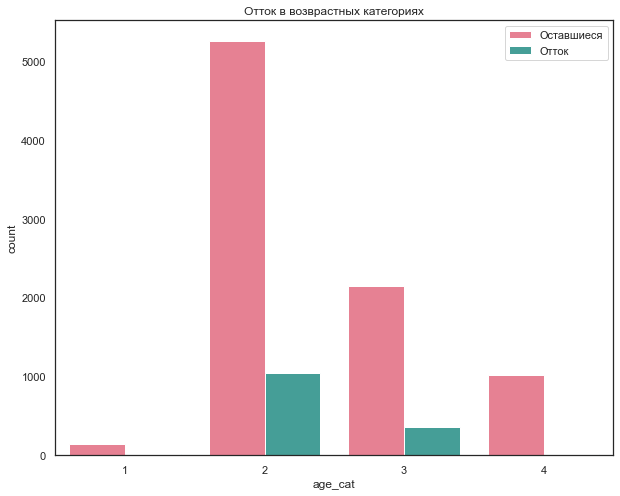

In [24]:
plt.figure(figsize = (10,8))
sns.countplot(x = 'age_cat' , hue = 'churn', data = df.sort_values(by ='age_cat', ascending = True),
              palette = 'husl').set_title('Отток в возврастных категориях')
plt.legend(['Оставшиеся', 'Отток']);

проверим как отток распределяется в возвратных гуппах по количеству используемых продуктов

<Figure size 2160x720 with 0 Axes>

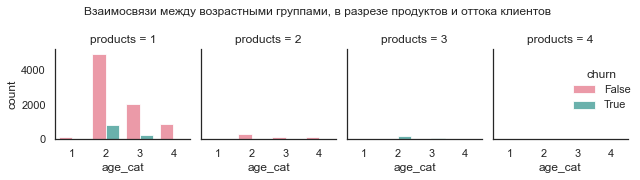

In [25]:
plt.figure(figsize = (30, 10))
sns.catplot (x = 'age_cat', col='products' , col_wrap=4,  hue = 'churn', kind = 'count' , 
              data = df.query('products != 0')[df.products.notnull()].sort_values(by = 'age_cat' , ascending = True),
              height=2.5, aspect=.8, alpha =0.8, palette = 'husl')
    
plt.suptitle('Взаимосвязи между возрастными группами, в разрезе продуктов и оттока клиентов')

plt.tight_layout();

В разрезе по возрастной группе, отток больше всего наблюдается среди клиентов среднего возраста (группа 2 до 45 лет),у клиентов испольлзующих один или три  продукта. Также величина оттока наблюдается при использовании только 1 продукта, среди возрастной группы (45-60 лет). В четвертом продукте такие клиенты есть, но их очень мало. 

## Изучение взаимосвязи между  группами кредитного рейтинга, в разрезе  оттока клиентов

In [26]:
def cat_2(row):
    if row < np.percentile(df.query('churn == 1')['score'], 25):
        return '1'
    return '2'
  
df['score_cat'] = df['score'].apply(cat_2)


С баллами кредитного рейтинга будем рассматривать только параметры оттока в рамках количества используемых продуктов, поскольку на остальные параметы кредитный рейтинг не будет оказывать влияния. Банку также важно, чтобы кредитный рейтинг клиента был высоким - это будет говорить о его надежности и платежеспособности, а также о том, что клиент не будет попадать в риск профиль по банкротству. Поскольку на графике распределения видно, что у банка высокий уровень оттока клиентов с высоким кредитным рейтингом, данное явление, может носить негативный характер. Проверим какая величина оттока у клиентов согласно разбиению по группам. 

In [27]:
round (df.query('products != 0').pivot_table( index = 'score_cat' , values ='churn', aggfunc = ['count' , 'mean']).reset_index(),3)


,score_cat,count,mean
,,churn,churn
0,1,6877,0.051
1,2,3122,0.347


 Наибольший отток у клиентов в группе 2 и 3 с высокими кредитными рейтингами (балл кредитного рейтинга от 687 и выше).  

## Промежуточные итоги: 

1. Наибольшее влияние на отток оказывают следующие параметры: 
* `products`,
* `score`,
* `age`

2. Наибольший отток наблюдается среди клиентов использующих 3, 4, 1 продукты. Клиенты использующие 1 продукт уходят реже. 
3. Мы можем сегментировать клиентов следующим образом: 
    3.1 по оттоку в группе продуктов  `products`
    * сегмент с 3 продуктами где наблюдается максимальный отток с более чем 50% перцентили.
    * сегмент с 4 и 1 продуктом, где средняя величина оттока
    * сегмент с 2 продуктами, где отток не наблюдается
    3.2 по значенияю `score` клиенты с хорошей оценкой скоринга 
    * от 50% перцентили и выше хоршие показатели скоринга, 
    * ниже 50% перцнтили низкие показатели скоринга
    3.3 по возарастному сегменту клиентов 

# <a name="segment"> Сегментация клиентов </a> 


* Написание функции для сегментирования клиентов
* Сегменты в разрезе оттока
* Доля оттока в зависомости от города по сегментации клиентов
* Доля оттока в разрезе использования кредитных карт по сегментированным клиентам



Дальнейшее деление по трем признакам `products` -`score` - `age_cat` не будет иметь смысла, потому что сделать группы мелкими, так как в группах 3 и 4 отток по количеству менее 200, в `score` отток по количеству подуктов основной приходился на 3 и 4 продукта, т.е. это сделает группы еще более мелкими.
 
 
 
 Именно поэтому делить будем на основании двух признаков `products`- `age_cat`, посмотрим на сводной таблице как это будет выглядеть:

In [28]:
df_res = df.query('products != [0, 2]').pivot_table( index = ['products' , 'age_cat' ], 
            values = 'churn', aggfunc = ['count','mean']).reset_index()
df_res.columns = ['products' , 'age_cat' , 'counted' , 'mean_churn']
df_res['cnt_churn'] = df_res['counted']*df_res['mean_churn']
df_res

,products,age_cat,counted,mean_churn,cnt_churn
0,1,1,158,0.101266,16.0
1,1,2,5804,0.142660,828.0
2,1,3,2296,0.116289,267.0
3,1,4,903,0.012182,11.0
4,3,2,213,1.000000,213.0
5,3,3,88,1.000000,88.0
6,3,4,5,1.000000,5.0
7,4,2,7,1.000000,7.0
8,4,3,1,1.000000,1.0


* пользователей использующих 4 продукта, объединим с пользователеями использующими 3 продукта, не взирая на возрастной признак, так как группы получаются слишком маленькие,

* пользователи использующие 1 продукт придется объединить по возрастному признаку групп 1, 3 и 4. 
* пользователи использующие 1 продукт и попадающие во 2 возрастную группу попадают в отдельный сегмент


 Напишем ф-ю для добавления дополнительного столбца в датасет с сегментами, так будет удобнее проводить филльтрацию в коде и при построении графиков. 

## Написание функции для сегментирования клиентов

In [29]:
def seg(data):
    
    if (data['products'] == 1) and (data['age_cat'] == '2'):
        return 'segment 1'
    
    if (data['products'] == 1 )and (data['age_cat'] == '1' or data['age_cat'] == '3' or data['age_cat'] == '4' ):
        return 'segment 2'
                                  
    if data['products'] >= 3:
        return 'segment 3'
    return 'segment 0'
    
df['segments'] = df.apply(seg, axis=1)
# какое количество отточных сегментов в группах 
df.query('churn ==1')['segments'].value_counts()


segment 1    828
segment 3    314
segment 2    294
segment 0      1
Name: segments, dtype: int64

## Сегменты в разрезе оттока

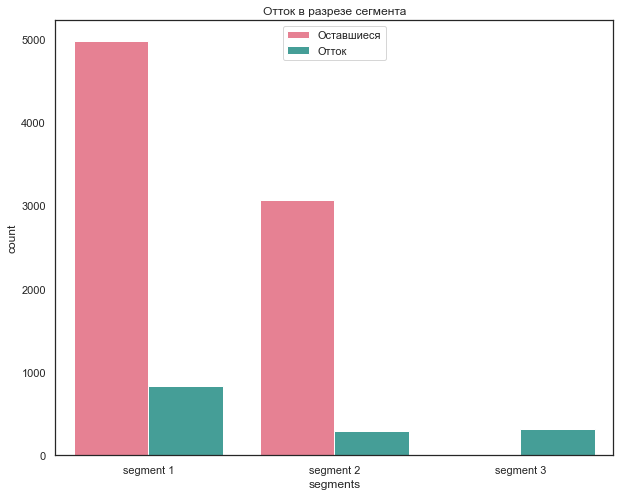

In [30]:
plt.figure(figsize = (10,8))
sns.countplot(x ='segments' , hue = 'churn' , data = df.query('segments != "segment 0"').sort_values(by ='segments' , ascending = True),
              palette = 'husl').set_title('Отток в разрезе сегмента')
plt.legend(['Оставшиеся', 'Отток']);

## Доля оттока в зависомости от города по сегментации клиентов

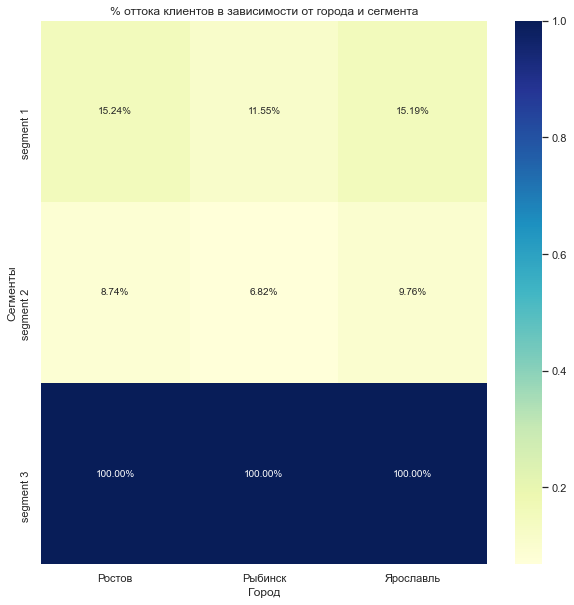

In [31]:
df_seg_piv = df.query('segments != "segment 0"').pivot_table(index = 'segments' , columns = 'city' , values = 'churn' , aggfunc = 'mean')


plt.figure(figsize=(10, 10))
plt.title('% оттока клиентов в зависимости от города и сегмента')
sns.heatmap(df_seg_piv, annot=True, fmt='.2%',  cmap="YlGnBu")
plt.xlabel('Город') 
plt.ylabel('Сегменты'); 

В целом наибольший отток в 1 сегменте, если помнить о количестве уходящих клиентов в этом сегменте, затем отток высокий в 3 сегменте, в сравнении оттоков по городам оттока-клиентов

## Доля оттока в разрезе использования кредитных карт по сегментированным клиентам

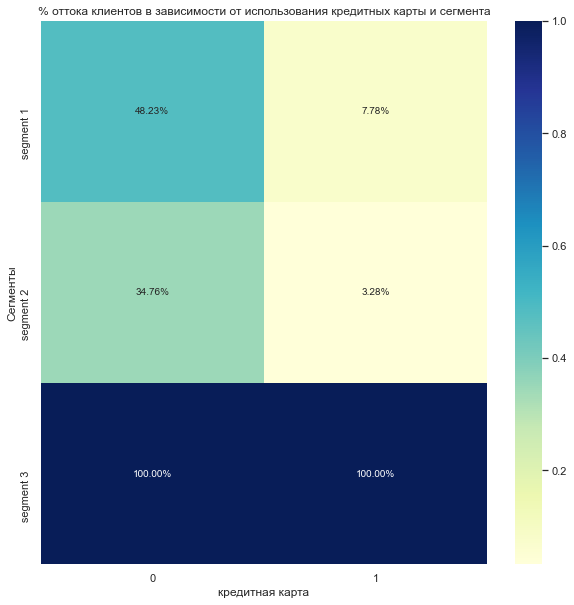

In [32]:
df_seg_cc = df.query('segments != "segment 0"').pivot_table(index = 'segments' , columns = 'credit_card' , values = 'churn' , aggfunc = 'mean')


plt.figure(figsize=(10, 10))
plt.title('% оттока клиентов в зависимости от использования кредитных карты и сегмента')
sns.heatmap(df_seg_cc, annot=True, fmt='.2%',  cmap="YlGnBu")
plt.xlabel('кредитная карта') 
plt.ylabel('Сегменты'); 

## Промежуточные итоги: 


Наибольший отток у нас среди клиентов `Segment 1`(клиенты использующие 1 продукт, возрастной группы 25-45 лет) :

- для этих сегментов следует рассмотреть более выгодные тарифы обслуживания по продуктам, так как видно, что клиенты после использования одного продукта уходят. Можно предположить, что качество продуктов и оказываемых услуг оставляет желать лучшего. 
- В основном уходят  клиенты из Ярославля и Ростова это около 13 % уходящих клиентов в каждом из городов. Необходимо рассмотреть тщательнее линейки предлагаемых клиентам продуктов. 
- Стоит рассмотреть варианты повышенных кэшбеков, например за использование кредитных карт


`Segment 3`(клиенты использующие 3-4 продукта всех возрастных групп, преимущественно возрастной группы 25-45 лет):
Поскольку клиенты используют больше  двух продуктов, данная группа должна быть приоритетной, необходимо разрабоать меры лояльности к таким клиентам.

- стоит добавить льготные условия обслуживания для клиентов молодого возраста, например до 25 лет, чтобы клиентов можно было привязать дебетовыми картами, 
- чаще из этого сегмента уходят клиенты, которые не пользовались кредитными картами. Отток по кредитным картам составляет 100% - это все приходящие клиенты,
- для клиентов молодой возрастной категори также стоит рассмотреть кредитные карты с льготным периодом большим по сроку, чем для остальных групп,
- договорится с партнерами о системе партнерских скидок, в рамках использования кредитных карт/дебетовых карт, для клиентов возрастной группы 25-45 лет. Такие как дополнительные скидки на развлечения массового характера (вероятнее всего это семейные категории клиентов), как аквапарки, кино, походы в супермаркет

`Segment 2`является следующим по величине оттока.  В данный сегмент попадают клиенты использующие только 1 продукт, разных возрастных категорий с минимальным оттоком в своей группе (преимущественно клиенты 45-60 лет) 

- стоит рассмотреть варианты, дополнительных бонусов от партнеров, для данной категории клиентов. Такие как дополнительные скидки на развлечения массового характера (вероятнее всего это семейные категории клиентов), как аквапарки, кино, походы в супермаркет, 

- возмоность введения льготных "привественных" тарифов на обслуживание, 

- Рассмотреть новые линейки продуктов  консервативных инструментов, 

- дополнительные повышенные кэшбеки, 

- повышенные ставки по вкладам для части клиентов у которых баланс на счете от определенной суммы


# <a name="check">  Проверка гипотез
</a>

* гипотеза 1: О различии дохода между клиентами использующими 1 и 2 продукта, 
* гипотеза 2: О различии дохода между клиентами использующими 3 и 4 продукт, 
* гипотеза 3: О различии дохода между клиентами-оттока с максимальным оттоком по сегментарной группе

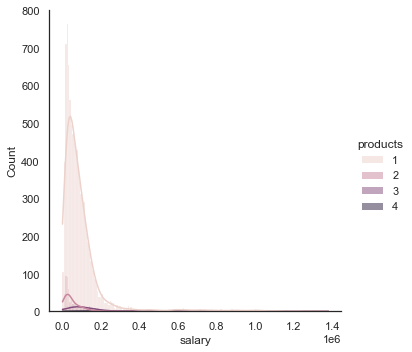

In [33]:
sns.displot(data = df.query('products !=0'), x= 'salary', hue = 'products', kde = True)

In [34]:
df.query('products !=0').pivot_table(index = 'products' , values = 'salary', aggfunc = 'count')

,salary
products,
1,9161
2,524
3,306
4,8


Распределение ненормальное,  но поскольку выбоки не равны между собой по размеру,  воспользуемся непараметрическим тестом Манна-Уитни. Напишем для этого функцию теста Манна-Уитни

In [35]:
def test (sample1, sample2):
        
    alpha = .05
    results = st.mannwhitneyu(sample1, sample2)
    print('p-значение: ', results.pvalue)
        
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 
           
    return


## Гипотеза 1

О различии дохода между клиентами использующими один и два продукта

* *H0 - Средний доход  клиентов использующих 1 продукт равен среднему доходу использующих 2 продукта;*
* *H1 - Средний доход  клиентов использующих 1 продукт НЕ равен среднему доходу использующих 2 продукта*

In [36]:
AB_prod1 = df.query('products ==1')['salary'] 
AB_prod2 = df.query('products ==2')['salary']

In [37]:
AB_prod12 = test(AB_prod1, AB_prod2)



p-значение:  1.1763819557266414e-39
Отвергаем нулевую гипотезу: разница статистически значима


Отвергаем нулевую гипотезу о равенстве средних доходов между клиентами использующими 1 и 2 продукта

## Гипотеза 2

О различии дохода между клиентами использующими 3 и 4 продукта

* *H0 - Средний доход  клиентов использующих 3 продукта равен среднему доходу использующих 4 продукта;*
* *H1 - Средний доход  клиентов использующих 3 продукта НЕ равен среднему доходу использующих 4 продукта*

In [38]:
AB_prod3 = df.query('products ==3')['salary']
AB_prod4 = df.query('products ==4')['salary']
AB_prod34 = test (AB_prod3, AB_prod4)

p-значение:  0.699912791822136
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Нулевую гипотезу о равенстве средних доходов между клиентами испольлзующими  3 и 4 продукта принимаем 

## Гипотеза 3


проверим гипотезу о  различии в доходе между клиентами-оттока между сегментами с макимальным оттоком
Поскольку максимальный отток в сегментах 2 и 1, сравним доходы клиентов в этих сегментах. 

* *H0 - Средний доход  клиентов во втором  сегменте равен среднему доходу клиентов в первом сегменте;*
* *H1 - Средний доход  клиентов во втором сегменте НЕ равен среднему доходу клиентов в первом сегменте*


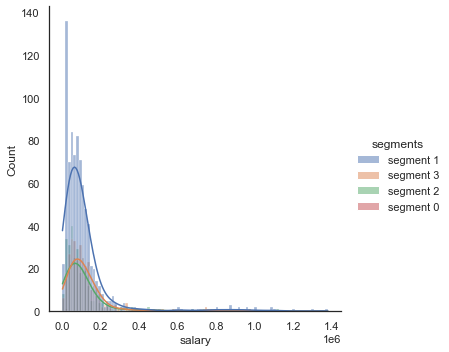

In [39]:
sns.displot(data = df.query('churn == 1'), x= 'salary', hue = 'segments', kde = True)

In [40]:
df.query('churn == 1 and segments == ["segment 1", "segment 2"]').pivot_table(index = 'segments', 
                    values = 'salary' , aggfunc = 'count')

,salary
segments,
segment 1,828
segment 2,294


Распределение носит характер ненормального, но выборки по размеру не равны

In [41]:
seg_1 = df.query('churn == 1 and segments == "segment 1"')['salary']

In [42]:
seg_2 = df.query('churn == 1 and segments == "segment 2"')['salary']


In [43]:
AB_seg24 = test(seg_1, seg_2)

p-значение:  0.488199575723821
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Получается, что у нас доходы между клиентами из сегмента 1 и сегмента 2 равны, между клиентами в доходе нет разницы.

# <a name="cncl">  Выводы
</a>

Наибольший отток наблюдается среди клиентов использующих только один продукт, три или четыре продукта, а также среди клиентов 2 и 3 ыозрастной группы (клиенты от 25 - 60 лет) среди клиентов до 25 лет и клиентов 60+ отток меньше. 

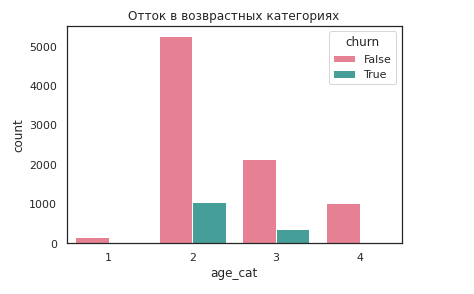

В результате чего клиенты были разделены на сегменты: 

Segment 0 – клиенты использующие два продукта, во всех возрастных категориях
Segment 1 – клиенты использующие только один продукт и относящиеся к возрастной группе до 32 лет 
Segment 2 – клиенты использующие только один продукт и относящиеся к возрастной группе до 46 лет
Segment 3 – клиенты использующие только один продукт и относящиеся к возрастной группе 46+
Segment 4 – клиенты использующие 3-4 продукта и относящиеся, ко всем трем возрастным  группам

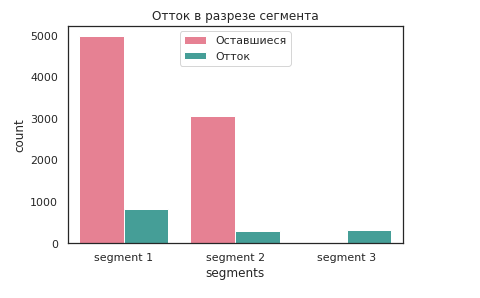

Также выяснили, что среди выделенных сегментов основной отток прихоится на клиентов из Ярославля и Ростова: 

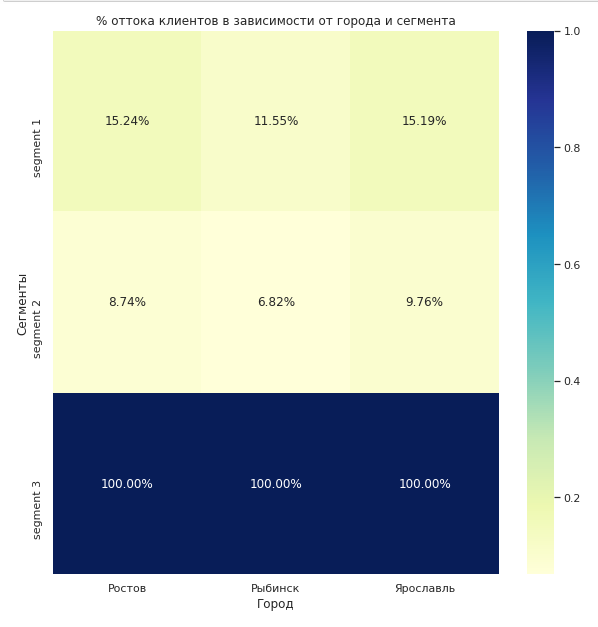


Наибольший отток у нас среди клиентов `Segment 1`(клиенты использующие 1 продукт, возрастной группы 25-45 лет) :

- для этих сегментов следует рассмотреть более выгодные тарифы обслуживания по продуктам, так как видно, что клиенты после использования одного продукта уходят. Можно предположить, что качество продуктов и оказываемых услуг оставляет желать лучшего. 
- В основном уходят  клиенты из Ярославля и Ростова это около 13 % уходящих клиентов в каждом из городов. Необходимо рассмотреть тщательнее линейки предлагаемых клиентам продуктов. 
- Стоит рассмотреть варианты повышенных кэшбеков, например за использование кредитных карт


`Segment 3`(клиенты использующие 3-4 продукта всех возрастных групп, преимущественно возрастной группы 25-45 лет):
Поскольку клиенты используют больше  двух продуктов, данная группа должна быть приоритетной, необходимо разрабоать меры лояльности к таким клиентам.

- стоит добавить льготные условия обслуживания для клиентов молодого возраста, например до 25 лет, чтобы клиентов можно было привязать дебетовыми картами, 
- чаще из этого сегмента уходят клиенты, которые не пользовались кредитными картами. Отток по кредитным картам составляет 100% - это все приходящие клиенты,
- для клиентов молодой возрастной категори также стоит рассмотреть кредитные карты с льготным периодом большим по сроку, чем для остальных групп,
- договорится с партнерами о системе партнерских скидок, в рамках использования кредитных карт/дебетовых карт, для клиентов возрастной группы 25-45 лет. Такие как дополнительные скидки на развлечения массового характера (вероятнее всего это семейные категории клиентов), как аквапарки, кино, походы в супермаркет

`Segment 2`является следующим по величине оттока.  В данный сегмент попадают клиенты использующие только 1 продукт, разных возрастных категорий с минимальным оттоком в своей группе (преимущественно клиенты 45-60 лет) 

- стоит рассмотреть варианты, дополнительных бонусов от партнеров, для данной категории клиентов. Такие как дополнительные скидки на развлечения массового характера (вероятнее всего это семейные категории клиентов), как аквапарки, кино, походы в супермаркет, 

- возмоность введения льготных "привественных" тарифов на обслуживание, 

- Рассмотреть новые линейки продуктов  консервативных инструментов, 

- дополнительные повышенные кэшбеки, 

- повышенные ставки по вкладам для части клиентов у которых баланс на счете от определенной суммы

